# TASK 3
# Прогнозування відтоку клієнтів за допомогою логістичної регресії

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

2: Завантаження та первинний огляд даних

In [2]:
df = pd.read_csv('customer_churn.csv')

print("Перші 5 рядків датасету:")
print(df.head())
print("\nІнформація про датасет:")
print(df.info())
print("\nСтатистичний опис:")
print(df.describe())
print("\nПеревірка на пропущені значення:")
print(df.isnull().sum())

Перші 5 рядків датасету:
              Names   Age  Total_Purchase  Account_Manager  Years  Num_Sites  \
0  Cameron Williams  42.0        11066.80                0   7.22        8.0   
1     Kevin Mueller  41.0        11916.22                0   6.50       11.0   
2       Eric Lozano  38.0        12884.75                0   6.67       12.0   
3     Phillip White  42.0         8010.76                0   6.71       10.0   
4    Cynthia Norton  37.0         9191.58                0   5.56        9.0   

          Onboard_date                                           Location  \
0  2013-08-30 07:00:40      10265 Elizabeth Mission Barkerburgh, AK 89518   
1  2013-08-13 00:38:46  6157 Frank Gardens Suite 019 Carloshaven, RI 1...   
2  2016-06-29 06:20:07             1331 Keith Court Alyssahaven, DE 90114   
3  2014-04-22 12:43:12       13120 Daniel Mount Angelabury, WY 30645-4695   
4  2016-01-19 15:31:15                765 Tricia Row Karenshire, MH 71730   

                       Company 

3: Аналіз цільової змінної

Розподіл цільової змінної Churn:
Churn
0    750
1    150
Name: count, dtype: int64

Процентний розподіл:
Churn
0    83.333333
1    16.666667
Name: proportion, dtype: float64


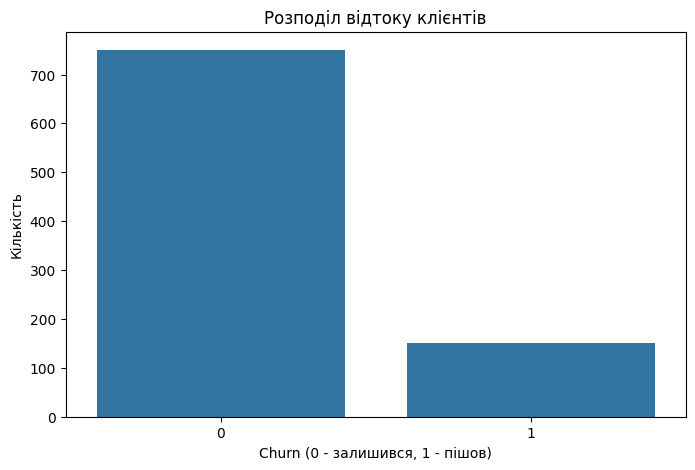

In [3]:
print("Розподіл цільової змінної Churn:")
print(df['Churn'].value_counts())
print("\nПроцентний розподіл:")
print(df['Churn'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Churn')
plt.title('Розподіл відтоку клієнтів')
plt.xlabel('Churn (0 - залишився, 1 - пішов)')
plt.ylabel('Кількість')
plt.show()

4: Exploratory Data Analysis (EDA)

Числові колонки для аналізу: ['Age', 'Total_Purchase', 'Years', 'Num_Sites']


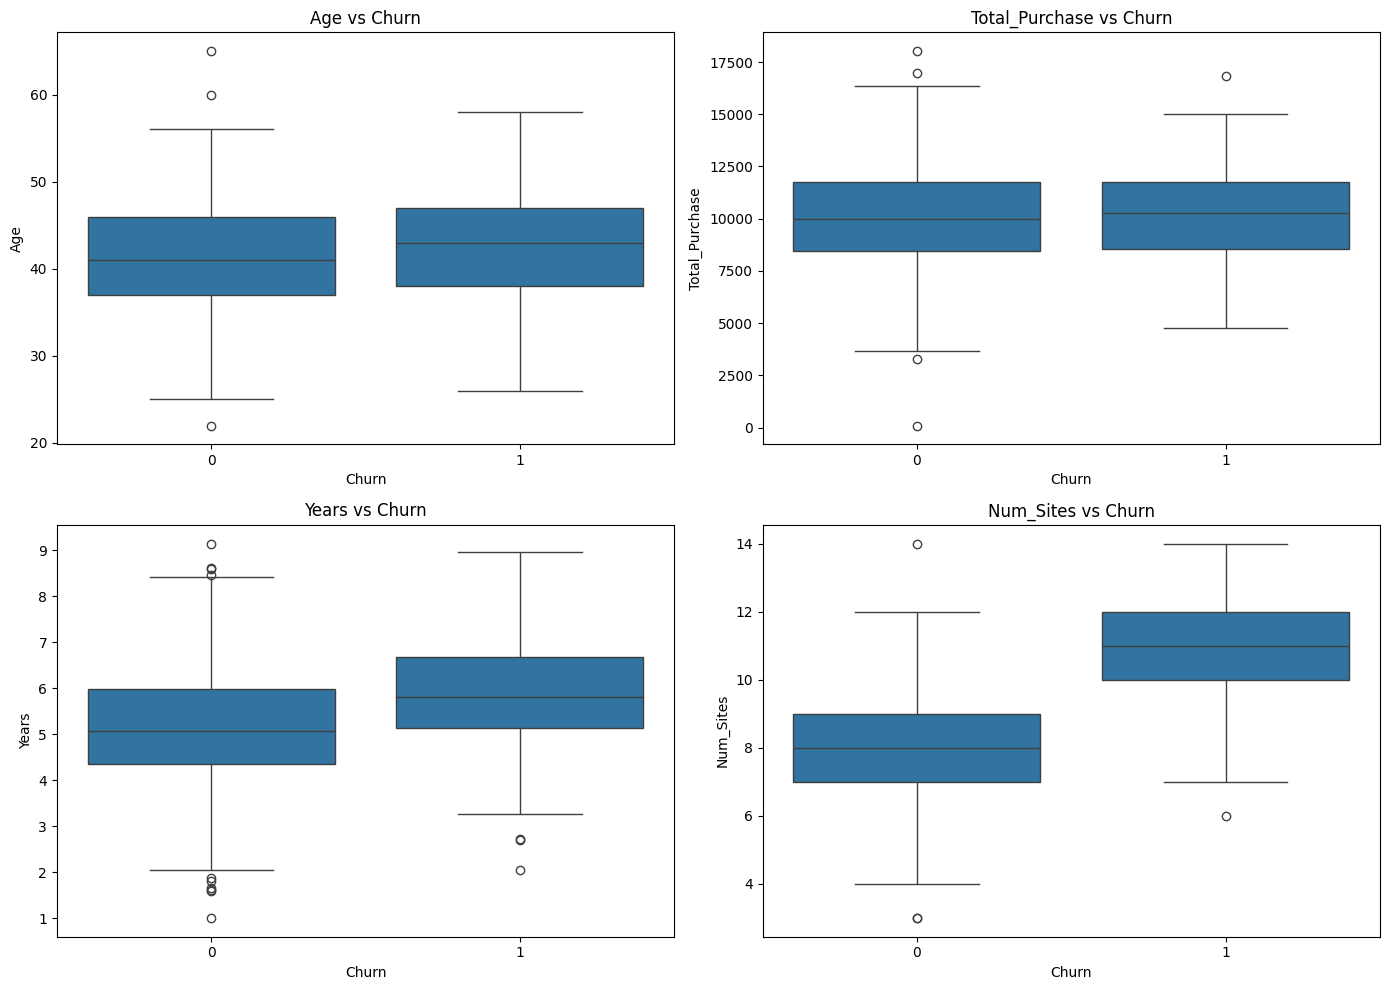

In [6]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'Churn' in numeric_cols:
    numeric_cols.remove('Churn')
if 'Account_Manager' in numeric_cols:
    numeric_cols.remove('Account_Manager')

print("Числові колонки для аналізу:", numeric_cols)

n_cols = len(numeric_cols)
n_rows = (n_cols + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    if col in df.columns:
        sns.boxplot(data=df, x='Churn', y=col, ax=axes[idx])
        axes[idx].set_title(f'{col} vs Churn')

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

5: Кореляційний аналіз

Колонки для кореляційного аналізу: ['Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Account_Manager', 'Churn']


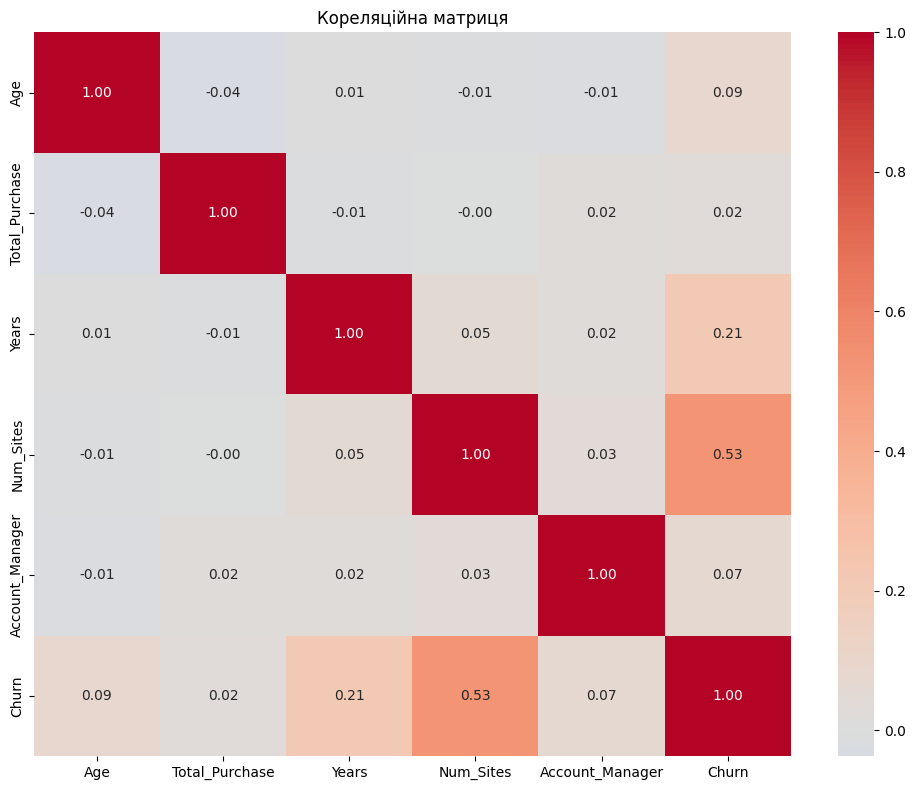


Кореляція з цільовою змінною Churn:
Churn              1.000000
Num_Sites          0.525398
Years              0.214329
Age                0.085926
Account_Manager    0.070611
Total_Purchase     0.024031
Name: Churn, dtype: float64


In [7]:
cols_for_corr = numeric_cols.copy()

if 'Account_Manager' in df.columns:
    cols_for_corr.append('Account_Manager')
if 'Churn' in df.columns:
    cols_for_corr.append('Churn')

print("Колонки для кореляційного аналізу:", cols_for_corr)

plt.figure(figsize=(10, 8))
correlation_matrix = df[cols_for_corr].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Кореляційна матриця')
plt.tight_layout()
plt.show()

print("\nКореляція з цільовою змінною Churn:")
if 'Churn' in correlation_matrix.columns:
    print(correlation_matrix['Churn'].sort_values(ascending=False))

6: Підготовка даних для моделювання

In [8]:
df_model = df.copy()

df_model['Onboard_date'] = pd.to_datetime(df_model['Onboard_date'])
df_model['Onboard_year'] = df_model['Onboard_date'].dt.year
df_model['Onboard_month'] = df_model['Onboard_date'].dt.month

columns_to_drop = ['Names', 'Location', 'Company', 'Onboard_date']
df_model = df_model.drop(columns=columns_to_drop)

print("Фічі для моделювання:")
print(df_model.columns.tolist())
print("\nФорма датасету:")
print(df_model.shape)

Фічі для моделювання:
['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Churn', 'Onboard_year', 'Onboard_month']

Форма датасету:
(900, 8)


7: Розділення на ознаки та цільову змінну

In [9]:
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

print("Форма X:", X.shape)
print("Форма y:", y.shape)
print("\nОзнаки моделі:")
print(X.columns.tolist())

Форма X: (900, 7)
Форма y: (900,)

Ознаки моделі:
['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Onboard_year', 'Onboard_month']


8: Розділення на тренувальну та тестову вибірки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Розмір тренувальної вибірки:", X_train.shape)
print("Розмір тестової вибірки:", X_test.shape)
print("\nРозподіл Churn у тренувальній вибірці:")
print(y_train.value_counts())
print("\nРозподіл Churn у тестовій вибірці:")
print(y_test.value_counts())

Розмір тренувальної вибірки: (630, 7)
Розмір тестової вибірки: (270, 7)

Розподіл Churn у тренувальній вибірці:
Churn
0    525
1    105
Name: count, dtype: int64

Розподіл Churn у тестовій вибірці:
Churn
0    225
1     45
Name: count, dtype: int64


 9: Масштабування ознак

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Масштабування завершено")
print("Середнє значення після масштабування:", X_train_scaled.mean(axis=0).round(2))
print("Стандартне відхилення після масштабування:", X_train_scaled.std(axis=0).round(2))

Масштабування завершено
Середнє значення після масштабування: [ 0. -0. -0. -0.  0.  0.  0.]
Стандартне відхилення після масштабування: [1. 1. 1. 1. 1. 1. 1.]


 10: Навчання моделі логістичної регресії

In [12]:
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

print("Модель успішно навчена")
print("\nКоефіцієнти моделі:")
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print(coefficients)

Модель успішно навчена

Коефіцієнти моделі:
           Feature  Coefficient
4        Num_Sites     1.891423
3            Years     0.726084
0              Age     0.290209
2  Account_Manager     0.264089
6    Onboard_month     0.134945
1   Total_Purchase     0.059822
5     Onboard_year     0.013197


 11: Прогнозування на тестовій вибірці

In [13]:
y_pred = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)[:, 1]

print("Прогнозування завершено")
print(f"Кількість передбачених відтоків: {y_pred.sum()}")
print(f"Кількість фактичних відтоків: {y_test.sum()}")

Прогнозування завершено
Кількість передбачених відтоків: 28
Кількість фактичних відтоків: 45


12: Оцінка моделі - Accuracy та Classification Report

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Accuracy у відсотках: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8926
Accuracy у відсотках: 89.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       225
           1       0.79      0.49      0.60        45

    accuracy                           0.89       270
   macro avg       0.85      0.73      0.77       270
weighted avg       0.89      0.89      0.88       270



13: Матриця помилок

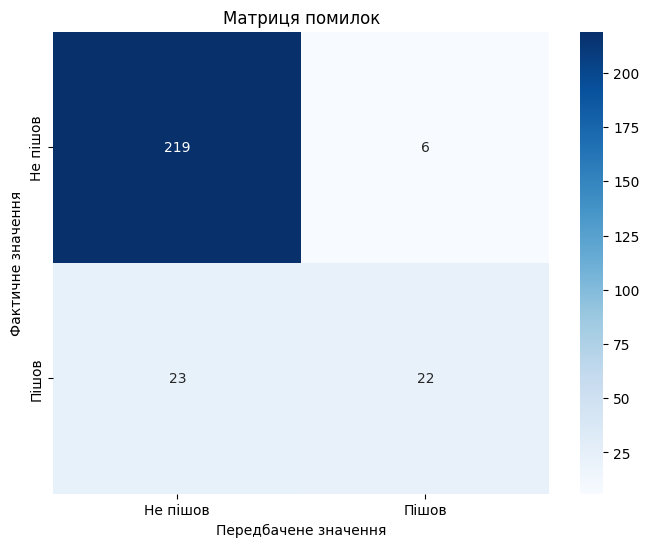


Інтерпретація матриці помилок:
True Negatives (правильно передбачені клієнти, що залишилися): 219
False Positives (помилково передбачені відтоки): 6
False Negatives (пропущені відтоки): 23
True Positives (правильно передбачені відтоки): 22


In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не пішов', 'Пішов'],
            yticklabels=['Не пішов', 'Пішов'])
plt.title('Матриця помилок')
plt.ylabel('Фактичне значення')
plt.xlabel('Передбачене значення')
plt.show()

print("\nІнтерпретація матриці помилок:")
print(f"True Negatives (правильно передбачені клієнти, що залишилися): {cm[0, 0]}")
print(f"False Positives (помилково передбачені відтоки): {cm[0, 1]}")
print(f"False Negatives (пропущені відтоки): {cm[1, 0]}")
print(f"True Positives (правильно передбачені відтоки): {cm[1, 1]}")

14: ROC-крива та AUC

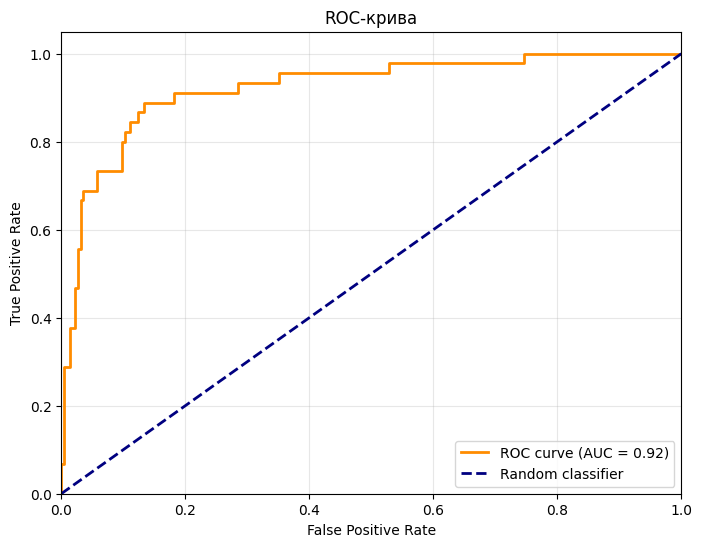

AUC Score: 0.9232


In [16]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-крива')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

15: Аналіз важливості ознак

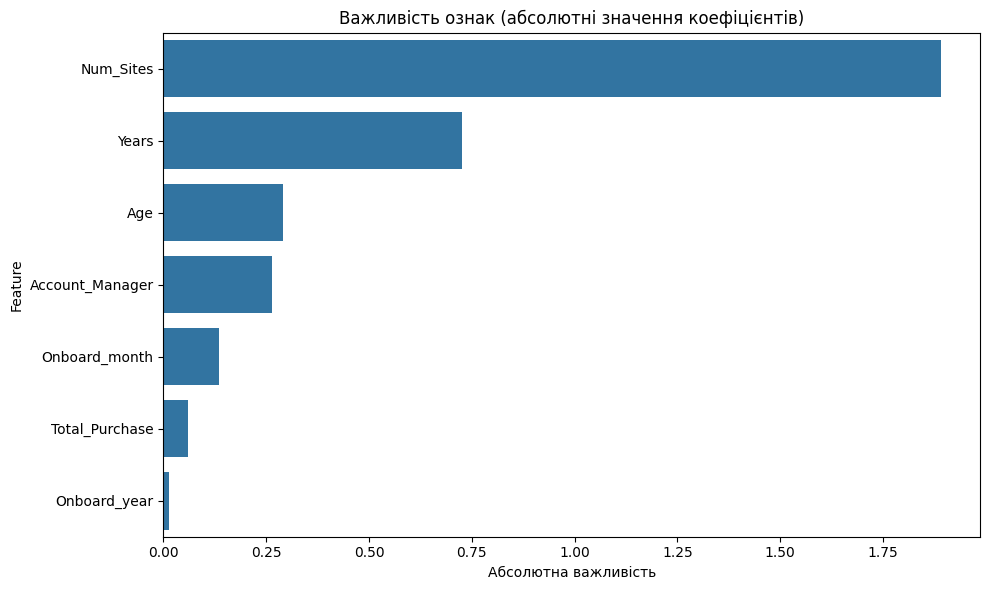

Топ-5 найважливіших ознак:
           Feature  Importance
4        Num_Sites    1.891423
3            Years    0.726084
0              Age    0.290209
2  Account_Manager    0.264089
6    Onboard_month    0.134945


In [17]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(log_model.coef_[0])
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Важливість ознак (абсолютні значення коефіцієнтів)')
plt.xlabel('Абсолютна важливість')
plt.tight_layout()
plt.show()

print("Топ-5 найважливіших ознак:")
print(feature_importance.head())

16: Завантаження нових клієнтів для прогнозування

In [20]:
new_customers = pd.read_csv('new_customers.csv')

print("Нові клієнти для прогнозування:")
print(new_customers.head())
print("\nІнформація про нових клієнтів:")
print(new_customers.info())
print("\nКількість нових клієнтів:", len(new_customers))

Нові клієнти для прогнозування:
                Names       Age  Total_Purchase  Account_Manager  Years  \
Andrew Mccall    37.0   9935.53               1             7.71    8.0   
Michele Wright   23.0   7526.94               1             9.28   15.0   
Jeremy Chang     65.0    100.00               1             1.00   15.0   
Megan Ferguson   32.0   6487.50               0             9.40   14.0   
Taylor Young     32.0  13147.71               1            10.00    8.0   

                          Num_Sites  \
Andrew Mccall   2011-08-29 18:37:54   
Michele Wright  2013-07-22 18:19:54   
Jeremy Chang    2006-12-11 07:48:13   
Megan Ferguson  2016-10-28 05:32:13   
Taylor Young    2012-03-20 00:36:46   

                                                     Onboard_date  \
Andrew Mccall   38612 Johnny Stravenue Nataliebury, WI 15717-8316   
Michele Wright  21083 Nicole Junction Suite 332, Youngport, ME...   
Jeremy Chang       085 Austin Views Lake Julialand, WY 63726-4298   
Megan 

17: Підготовка нових даних

In [23]:
new_customers_processed = new_customers.copy()

print("Колонка Num_Sites містить:")
print(new_customers_processed['Num_Sites'].head())
print("\nКолонка Onboard_date містить:")
print(new_customers_processed['Onboard_date'].head())

new_customers_processed['Onboard_date'] = pd.to_datetime(new_customers_processed['Num_Sites'])
new_customers_processed['Num_Sites'] = new_customers_processed['Account_Manager']
new_customers_processed['Account_Manager'] = new_customers_processed['Total_Purchase']
new_customers_processed['Total_Purchase'] = new_customers_processed['Age']
new_customers_processed['Age'] = new_customers_processed['Names']

new_customers_processed = new_customers_processed.drop('Names', axis=1)

new_customers_processed['Onboard_year'] = new_customers_processed['Onboard_date'].dt.year
new_customers_processed['Onboard_month'] = new_customers_processed['Onboard_date'].dt.month

print("\nВиправлені дані після перестановки:")
print(new_customers_processed.head())
print("\nІнформація:")
print(new_customers_processed.info())

columns_to_drop = ['Location', 'Company', 'Onboard_date']
new_customers_features = new_customers_processed.drop(columns=columns_to_drop)

print("\nОзнаки нових клієнтів після обробки:")
print(new_customers_features.columns.tolist())
print("\nФорма даних:", new_customers_features.shape)
print("\nПерші рядки фінальних ознак:")
print(new_customers_features.head())

Колонка Num_Sites містить:
Andrew Mccall     2011-08-29 18:37:54
Michele Wright    2013-07-22 18:19:54
Jeremy Chang      2006-12-11 07:48:13
Megan Ferguson    2016-10-28 05:32:13
Taylor Young      2012-03-20 00:36:46
Name: Num_Sites, dtype: object

Колонка Onboard_date містить:
Andrew Mccall     38612 Johnny Stravenue Nataliebury, WI 15717-8316
Michele Wright    21083 Nicole Junction Suite 332, Youngport, ME...
Jeremy Chang         085 Austin Views Lake Julialand, WY 63726-4298
Megan Ferguson        922 Wright Branch North Cynthialand, NC 64721
Taylor Young                        Unit 0789 Box 0734 DPO AP 39702
Name: Onboard_date, dtype: object

Виправлені дані після перестановки:
                 Age  Total_Purchase  Account_Manager  Years  Num_Sites  \
Andrew Mccall   37.0         9935.53                1    8.0       7.71   
Michele Wright  23.0         7526.94                1   15.0       9.28   
Jeremy Chang    65.0          100.00                1   15.0       1.00   
Megan Ferg

18: Масштабування нових даних

In [24]:
new_customers_scaled = scaler.transform(new_customers_features)

print("Нові дані масштабовано за допомогою того ж scaler")
print("Форма масштабованих даних:", new_customers_scaled.shape)

Нові дані масштабовано за допомогою того ж scaler
Форма масштабованих даних: (6, 7)


19: Прогнозування для нових клієнтів

In [26]:
new_predictions = log_model.predict(new_customers_scaled)
new_predictions_proba = log_model.predict_proba(new_customers_scaled)[:, 1]

print(f"Кількість клієнтів, які ймовірно підуть: {new_predictions.sum()}")
print(f"Кількість клієнтів, які ймовірно залишаться: {(new_predictions == 0).sum()}")

Кількість клієнтів, які ймовірно підуть: 3
Кількість клієнтів, які ймовірно залишаться: 3


20: Створення звіту про нових клієнтів


In [27]:
results = new_customers[['Names', 'Company']].copy()
results['Churn_Prediction'] = new_predictions
results['Churn_Probability'] = new_predictions_proba
results['Risk_Level'] = pd.cut(results['Churn_Probability'],
                                bins=[0, 0.3, 0.7, 1.0],
                                labels=['Низький', 'Середній', 'Високий'])

print("РЕЗУЛЬТАТИ ПРОГНОЗУВАННЯ ДЛЯ НОВИХ КЛІЄНТІВ:")
print("=" * 80)
print(results.to_string(index=False))
print("\n")

РЕЗУЛЬТАТИ ПРОГНОЗУВАННЯ ДЛЯ НОВИХ КЛІЄНТІВ:
 Names  Company  Churn_Prediction  Churn_Probability Risk_Level
  37.0      NaN                 0           0.122915    Низький
  23.0      NaN                 1           0.956097    Високий
  65.0      NaN                 0           0.020020    Низький
  32.0      NaN                 1           0.931987    Високий
  32.0      NaN                 1           0.538044   Середній
  22.0      NaN                 0           0.018140    Низький




21: Клієнти з високим ризиком відтоку

In [28]:
high_risk_customers = results[results['Churn_Prediction'] == 1].sort_values('Churn_Probability', ascending=False)

print("КЛІЄНТИ З ВИСОКИМ РИЗИКОМ ВІДТОКУ (потребують уваги менеджера):")
print("=" * 80)
if len(high_risk_customers) > 0:
    print(high_risk_customers.to_string(index=False))
    print(f"\nЗагальна кількість клієнтів з високим ризиком: {len(high_risk_customers)}")
else:
    print("Немає клієнтів з високим ризиком відтоку")

КЛІЄНТИ З ВИСОКИМ РИЗИКОМ ВІДТОКУ (потребують уваги менеджера):
 Names  Company  Churn_Prediction  Churn_Probability Risk_Level
  23.0      NaN                 1           0.956097    Високий
  32.0      NaN                 1           0.931987    Високий
  32.0      NaN                 1           0.538044   Середній

Загальна кількість клієнтів з високим ризиком: 3


22: Статистика за рівнями ризику


СТАТИСТИКА ЗА РІВНЯМИ РИЗИКУ:
Risk_Level
Низький     3
Середній    1
Високий     2
Name: count, dtype: int64

Процентний розподіл:
Risk_Level
Низький     50.000000
Середній    16.666667
Високий     33.333333
Name: proportion, dtype: float64


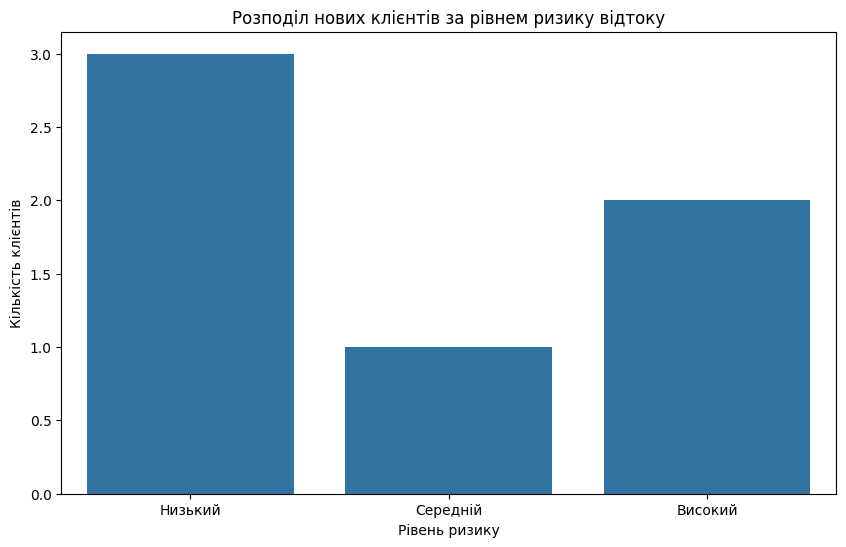

In [29]:
print("\nСТАТИСТИКА ЗА РІВНЯМИ РИЗИКУ:")
print("=" * 80)
risk_stats = results['Risk_Level'].value_counts().sort_index()
print(risk_stats)
print("\nПроцентний розподіл:")
print(results['Risk_Level'].value_counts(normalize=True).sort_index() * 100)

plt.figure(figsize=(10, 6))
sns.countplot(data=results, x='Risk_Level', order=['Низький', 'Середній', 'Високий'])
plt.title('Розподіл нових клієнтів за рівнем ризику відтоку')
plt.xlabel('Рівень ризику')
plt.ylabel('Кількість клієнтів')
plt.show()

23: Збереження результатів

In [30]:
results.to_csv('customer_churn_predictions.csv', index=False, encoding='utf-8-sig')
high_risk_customers.to_csv('high_risk_customers.csv', index=False, encoding='utf-8-sig')

print("Результати збережено у файли:")
print("- customer_churn_predictions.csv (всі клієнти)")
print("- high_risk_customers.csv (клієнти з високим ризиком)")

Результати збережено у файли:
- customer_churn_predictions.csv (всі клієнти)
- high_risk_customers.csv (клієнти з високим ризиком)


# 24: Висновки та рекомендації

In [31]:
print("\n" + "=" * 80)
print("ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ")
print("=" * 80)
print(f"\n1. ЯКІСТЬ МОДЕЛІ:")
print(f"   - Точність (Accuracy): {accuracy * 100:.2f}%")
print(f"   - AUC Score: {roc_auc:.4f}")
print(f"\n2. ПРОГНОЗ ДЛЯ НОВИХ КЛІЄНТІВ:")
print(f"   - Загальна кількість нових клієнтів: {len(new_customers)}")
print(f"   - Клієнтів з ризиком відтоку: {new_predictions.sum()}")
print(f"   - Клієнтів, які ймовірно залишаться: {(new_predictions == 0).sum()}")
print(f"\n3. РЕКОМЕНДАЦІЇ:")
print(f"   - Призначити менеджерів клієнтам з високим ризиком відтоку")
print(f"   - Звернути особливу увагу на клієнтів з ймовірністю відтоку > 70%")
print(f"   - Розробити програми утримання для клієнтів середнього ризику")
print("=" * 80)


ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ

1. ЯКІСТЬ МОДЕЛІ:
   - Точність (Accuracy): 89.26%
   - AUC Score: 0.9232

2. ПРОГНОЗ ДЛЯ НОВИХ КЛІЄНТІВ:
   - Загальна кількість нових клієнтів: 6
   - Клієнтів з ризиком відтоку: 3
   - Клієнтів, які ймовірно залишаться: 3

3. РЕКОМЕНДАЦІЇ:
   - Призначити менеджерів клієнтам з високим ризиком відтоку
   - Звернути особливу увагу на клієнтів з ймовірністю відтоку > 70%
   - Розробити програми утримання для клієнтів середнього ризику


# **25: Завантаження та повний звіт з прогнозів**

In [33]:
predictions_df = pd.read_csv('customer_churn_predictions.csv')
high_risk_df = pd.read_csv('high_risk_customers.csv')

print("=" * 80)
print("ВСІ ПРОГНОЗИ ДЛЯ НОВИХ КЛІЄНТІВ")
print("=" * 80)
print(predictions_df.to_string(index=False))

print("\n" + "=" * 80)
print("СТАТИСТИКА ПРОГНОЗІВ")
print("=" * 80)
print(f"Загальна кількість клієнтів: {len(predictions_df)}")
print(f"Клієнтів з прогнозом відтоку (Churn=1): {predictions_df['Churn_Prediction'].sum()}")
print(f"Клієнтів, які ймовірно залишаться (Churn=0): {(predictions_df['Churn_Prediction'] == 0).sum()}")
print("\nРозподіл за рівнями ризику:")
print(predictions_df['Risk_Level'].value_counts().sort_index())

print("\n" + "=" * 80)
print("КЛІЄНТИ З ВИСОКИМ РИЗИКОМ ВІДТОКУ")
print("=" * 80)
if len(high_risk_df) > 0:
    print(high_risk_df.to_string(index=False))
    print(f"\n\nСередня ймовірність відтоку: {high_risk_df['Churn_Probability'].mean():.2%}")
    print(f"Максимальна ймовірність відтоку: {high_risk_df['Churn_Probability'].max():.2%}")
else:
    print("Немає клієнтів з високим ризиком відтоку")

print("\n" + "=" * 80)
print("ДЕТАЛЬНИЙ ЗВІТ ПО КОЖНОМУ КЛІЄНТУ")
print("=" * 80)
for idx, row in predictions_df.iterrows():
    print(f"\nКлієнт #{idx + 1}: {row['Names']} ({row['Company']})")
    print(f"  Прогноз: {'ПІДЕ' if row['Churn_Prediction'] == 1 else 'ЗАЛИШИТЬСЯ'} | Ймовірність: {row['Churn_Probability']:.2%} | Ризик: {row['Risk_Level']}")
    if row['Churn_Prediction'] == 1:
        print(f"  РЕКОМЕНДАЦІЯ: Призначити менеджера та розробити план утримання")
    elif row['Risk_Level'] == 'Середній':
        print(f"  РЕКОМЕНДАЦІЯ: Моніторити активність клієнта")
    else:
        print(f"  РЕКОМЕНДАЦІЯ: Підтримувати поточний рівень обслуговування")

high_risk_count = (predictions_df['Churn_Prediction'] == 1).sum()
medium_risk_count = (predictions_df['Risk_Level'] == 'Середній').sum()
low_risk_count = (predictions_df['Risk_Level'] == 'Низький').sum()

print("\n" + "=" * 80)
print("ФІНАЛЬНІ РЕКОМЕНДАЦІЇ")
print("=" * 80)
print(f"\nПРІОРИТЕТ 1 - ВИСОКИЙ РИЗИК ({high_risk_count} клієнтів):")
if high_risk_count > 0:
    print("  Негайно призначити менеджера, провести зустріч, запропонувати спецумови")
    for _, row in predictions_df[predictions_df['Churn_Prediction'] == 1].iterrows():
        print(f"  - {row['Names']} ({row['Company']}) - {row['Churn_Probability']:.1%}")
else:
    print("  Немає клієнтів")
print(f"\nПРІОРИТЕТ 2 - СЕРЕДНІЙ РИЗИК ({medium_risk_count} клієнтів): Посилити комунікацію, моніторити")
print(f"ПРІОРИТЕТ 3 - НИЗЬКИЙ РИЗИК ({low_risk_count} клієнтів): Підтримувати сервіс")
print("=" * 80)

ВСІ ПРОГНОЗИ ДЛЯ НОВИХ КЛІЄНТІВ
 Names  Company  Churn_Prediction  Churn_Probability Risk_Level
  37.0      NaN                 0           0.122915    Низький
  23.0      NaN                 1           0.956097    Високий
  65.0      NaN                 0           0.020020    Низький
  32.0      NaN                 1           0.931987    Високий
  32.0      NaN                 1           0.538044   Середній
  22.0      NaN                 0           0.018140    Низький

СТАТИСТИКА ПРОГНОЗІВ
Загальна кількість клієнтів: 6
Клієнтів з прогнозом відтоку (Churn=1): 3
Клієнтів, які ймовірно залишаться (Churn=0): 3

Розподіл за рівнями ризику:
Risk_Level
Високий     2
Низький     3
Середній    1
Name: count, dtype: int64

КЛІЄНТИ З ВИСОКИМ РИЗИКОМ ВІДТОКУ
 Names  Company  Churn_Prediction  Churn_Probability Risk_Level
  23.0      NaN                 1           0.956097    Високий
  32.0      NaN                 1           0.931987    Високий
  32.0      NaN                 1          

# **26: Візуалізація прогнозів**

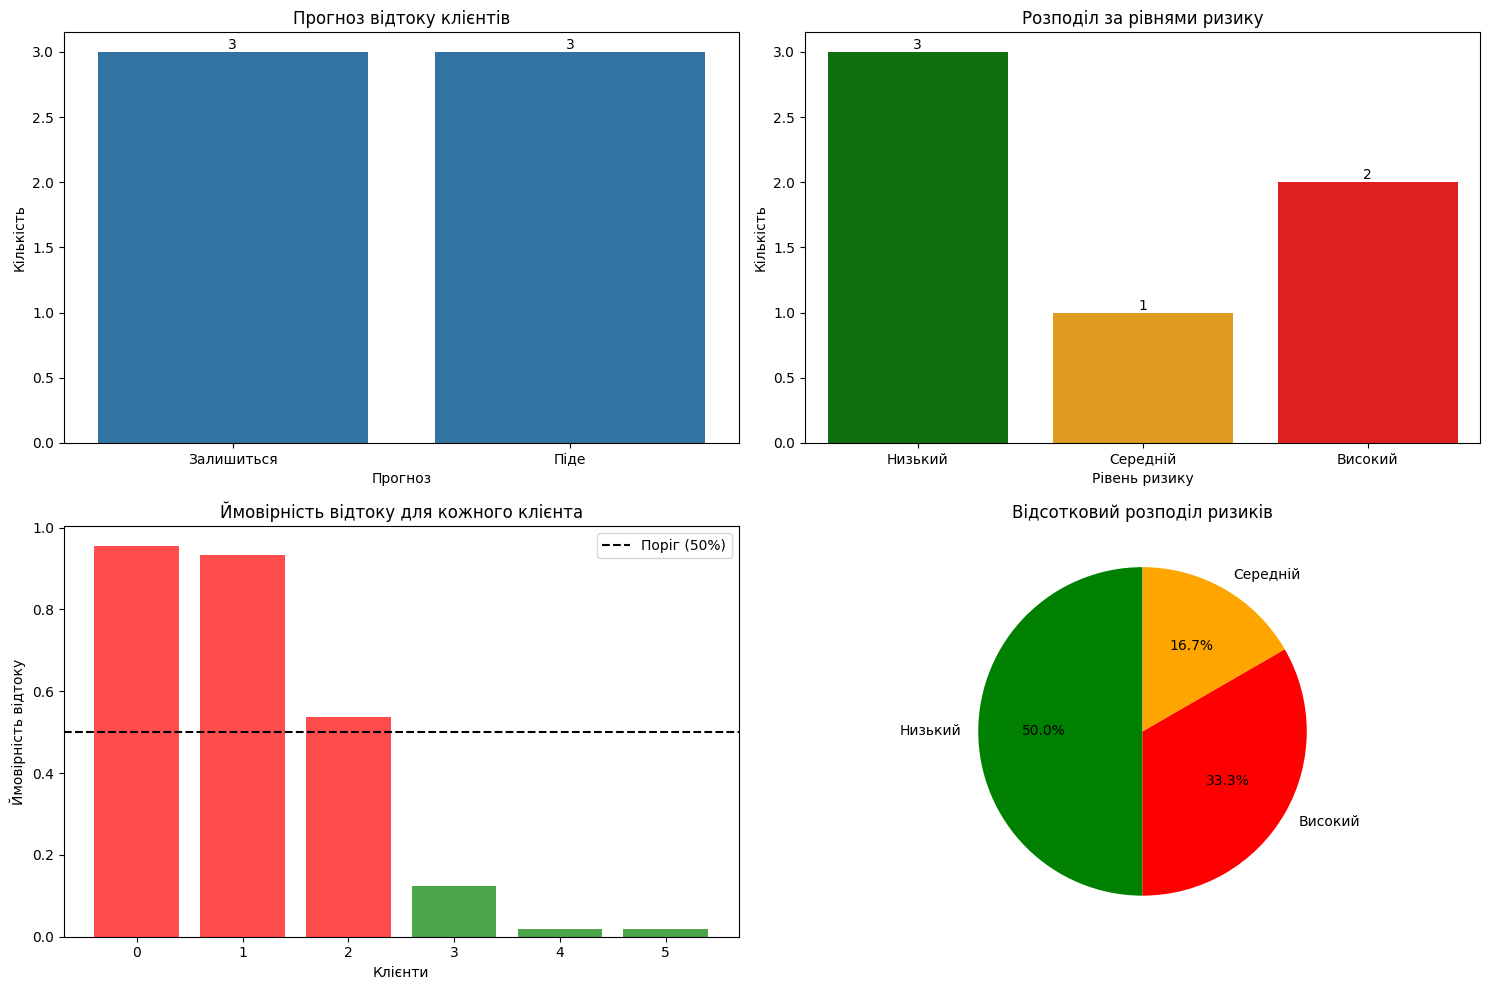

Візуалізація завершена


In [34]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

predictions_df['Churn_Label'] = predictions_df['Churn_Prediction'].map({0: 'Залишиться', 1: 'Піде'})
sns.countplot(data=predictions_df, x='Churn_Label', ax=axes[0, 0])
axes[0, 0].set_title('Прогноз відтоку клієнтів')
axes[0, 0].set_xlabel('Прогноз')
axes[0, 0].set_ylabel('Кількість')
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container)

risk_order = ['Низький', 'Середній', 'Високий']
colors = ['green', 'orange', 'red']
color_map = {level: color for level, color in zip(risk_order, colors)}
sns.countplot(data=predictions_df, x='Risk_Level', order=risk_order, palette=color_map, ax=axes[0, 1])
axes[0, 1].set_title('Розподіл за рівнями ризику')
axes[0, 1].set_xlabel('Рівень ризику')
axes[0, 1].set_ylabel('Кількість')
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container)

predictions_sorted = predictions_df.sort_values('Churn_Probability', ascending=False).reset_index(drop=True)
bar_colors = ['red' if pred == 1 else 'green' for pred in predictions_sorted['Churn_Prediction']]
axes[1, 0].bar(range(len(predictions_sorted)), predictions_sorted['Churn_Probability'], color=bar_colors, alpha=0.7)
axes[1, 0].axhline(y=0.5, color='black', linestyle='--', label='Поріг (50%)')
axes[1, 0].set_xlabel('Клієнти')
axes[1, 0].set_ylabel('Ймовірність відтоку')
axes[1, 0].set_title('Ймовірність відтоку для кожного клієнта')
axes[1, 0].legend()

pie_data = predictions_df['Risk_Level'].value_counts()
pie_colors = [color_map.get(level, 'gray') for level in pie_data.index]
axes[1, 1].pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', colors=pie_colors, startangle=90)
axes[1, 1].set_title('Відсотковий розподіл ризиків')

plt.tight_layout()
plt.show()

print("Візуалізація завершена")